In [ ]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor, Lambda, Compose
import matplotlib.pyplot as plt

Load data into a DataLoader

In [ ]:
training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor()
)

test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor()
)

batch_size = 64

train_dataloader = DataLoader(training_data, batch_size=batch_size)
test_dataloader = DataLoader(test_data, batch_size=batch_size)

for X, y in test_dataloader:
    print("Shape of X[N,C,H,W]: {}".format(X.shape))
    print("Shape of y: {}".format(y.shape))
    break

Shape of X[N,C,H,W]: torch.Size([64, 1, 28, 28])
Shape of y: torch.Size([64])


### Displaying an image with matplotlib.

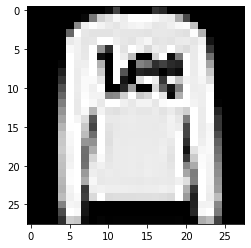

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

image = X[1][0]

fig = plt.figure
plt.imshow(image, cmap='gray')
plt.show()

### Displaying an image with iPython display.

In [ ]:
from PIL import Image
import numpy as np

grayscale_img = np.uint8(X[50][0].numpy() * 255)
i = Image.fromarray(grayscale_img, 'L')
display(i)

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using {} device...".format(device))

Using cuda device...


### Define the Neural Network structure

In [ ]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 10),
            nn.ReLU()
        )
        
    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits
    
model = NeuralNetwork().to(device)
print(model)


NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=10, bias=True)
    (5): ReLU()
  )
)


In [ ]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)

def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)
        
        # Compute the prediction error
        pred = model(X)
        loss = loss_fn(pred, y)
        
        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f} [{current:>5d}/{size:>5d}]")

In [ ]:
def test(dataloader, model):
    size = len(dataloader.dataset)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= size
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")


### Now run the train/test cycle and see how it learns over time

In [ ]:
epochs = 20
for t in range(epochs):
    print("Epoch {} \n----------------------------------".format(t))
    train(train_dataloader, model, loss_fn, optimizer)
    test(test_dataloader, model)
print("Done!")


Epoch 0 
----------------------------------
loss: 2.296443 [    0/60000]
loss: 2.292342 [ 6400/60000]
loss: 2.279121 [12800/60000]
loss: 2.278732 [19200/60000]
loss: 2.276874 [25600/60000]
loss: 2.251575 [32000/60000]
loss: 2.242615 [38400/60000]
loss: 2.222303 [44800/60000]
loss: 2.232987 [51200/60000]
loss: 2.195560 [57600/60000]
Test Error: 
 Accuracy: 41.1%, Avg loss: 0.034725 

Epoch 1 
----------------------------------
loss: 2.213381 [    0/60000]
loss: 2.224470 [ 6400/60000]
loss: 2.170785 [12800/60000]
loss: 2.183640 [19200/60000]
loss: 2.179667 [25600/60000]
loss: 2.103505 [32000/60000]
loss: 2.128769 [38400/60000]
loss: 2.074262 [44800/60000]
loss: 2.101092 [51200/60000]
loss: 2.015541 [57600/60000]
Test Error: 
 Accuracy: 42.6%, Avg loss: 0.032423 

Epoch 2 
----------------------------------
loss: 2.075792 [    0/60000]
loss: 2.104152 [ 6400/60000]
loss: 1.985915 [12800/60000]
loss: 2.020382 [19200/60000]
loss: 2.020219 [25600/60000]
loss: 1.879080 [32000/60000]
loss: 1.94

In [ ]:
torch.save(model.state_dict(), "pytorch_quickstart.pth")
print("Saved model to pytorch_quickstart.pth")

Saved model to pytorch_quickstart.pth


### Now load the model and make some predictions

In [ ]:
model = NeuralNetwork()
model.load_state_dict(torch.load("pytorch_quickstart.pth"))

<All keys matched successfully>

In [ ]:
classes = [
    "T-shirt/top",
    "Trouser",
    "Pullover",
    "Dress",
    "Coat",
    "Sandal",
    "Shirt",
    "Sneaker",
    "Bag",
    "Ankle boot",
]

model.eval()
x, y = test_data[0][0], test_data[0][1]
with torch.no_grad():
    pred = model(x)
    predicted, actual = classes[pred[0].argmax(0)], classes[y]
    print(f'Predicted: "{predicted}", Actual: "{actual}"')
    


Predicted: "Ankle boot", Actual: "Ankle boot"


In [ ]:
test_data

Dataset FashionMNIST
    Number of datapoints: 10000
    Root location: data
    Split: Test
    StandardTransform
Transform: ToTensor()

In [ ]:
sample = test_data[0]
print("Elements of dataset are of type: {} and have length: {}".format(type(sample), len(sample)))

Elements of dataset are of type: <class 'tuple'> and have length: 2


In [ ]:
sample[0]

tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,

In [ ]:
sample[1]

9